# Churn Drivers Analysis

Which user behaviors and characteristics are associated with higher churn rates?

In [15]:
from google.cloud import bigquery
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings('ignore')
load_dotenv()

GCP_PROJECT = os.environ.get("GCP_PROJECT")
client = bigquery.Client(project=GCP_PROJECT)

def run_query(sql):
    return client.query(sql).to_dataframe()

## Demographics and Churn

In [16]:
# Churn rate by gender (valid gender only)
run_query("""
SELECT 
    m.gender,
    COUNT(*) as users,
    SUM(t.is_churn) as churned,
    ROUND(SUM(t.is_churn) * 100.0 / COUNT(*), 1) as churn_rate
FROM kkbox.train t
JOIN kkbox.members m ON t.msno = m.msno
WHERE m.gender IS NOT NULL
GROUP BY m.gender
ORDER BY users DESC
""")

,gender,users,churned,churn_rate
0,male,204561,26396,12.9
1,female,184344,23940,13.0


Gender shows no meaningful difference in churn rates. Male users churn at 12.9%, female at 13.0%. Gender is not a useful predictor of churn.

In [17]:
# Churn rate by age group (valid ages only)
age_churn_df = run_query("""
SELECT 
    CASE 
        WHEN m.bd BETWEEN 13 AND 17 THEN '13-17'
        WHEN m.bd BETWEEN 18 AND 24 THEN '18-24'
        WHEN m.bd BETWEEN 25 AND 34 THEN '25-34'
        WHEN m.bd BETWEEN 35 AND 44 THEN '35-44'
        WHEN m.bd BETWEEN 45 AND 54 THEN '45-54'
        WHEN m.bd BETWEEN 55 AND 64 THEN '55-64'
        WHEN m.bd BETWEEN 65 AND 79 THEN '65-79'
        ELSE '80+'
    END as age_group,
    COUNT(*) as users,
    SUM(t.is_churn) as churned,
    ROUND(SUM(t.is_churn) * 100.0 / COUNT(*), 1) as churn_rate
FROM kkbox.train t
JOIN kkbox.members m ON t.msno = m.msno
WHERE m.bd BETWEEN 13 AND 100
GROUP BY age_group
ORDER BY MIN(m.bd)
""")
age_churn_df

,age_group,users,churned,churn_rate
0,13-17,9650,2723,28.2
1,18-24,104948,19304,18.4
2,25-34,177130,19614,11.1
3,35-44,66310,6999,10.6
4,45-54,22122,2074,9.4
5,55-64,5257,462,8.8
6,65-79,923,107,11.6
7,80+,229,22,9.6


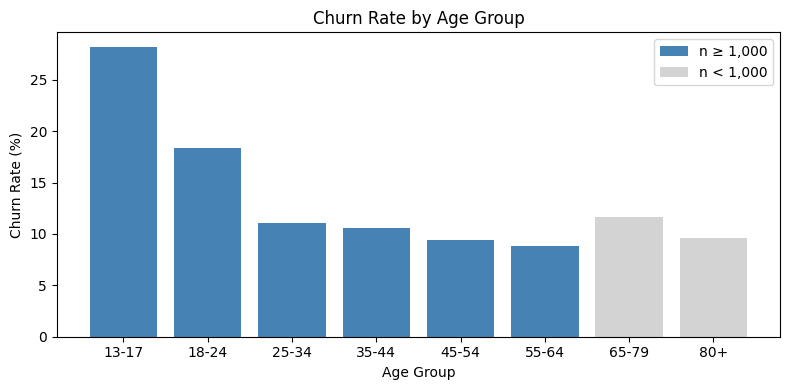

In [18]:
# Churn rate by age group
fig, ax = plt.subplots(figsize=(8, 4))
colors = ['lightgray' if n < 1000 else 'steelblue' for n in age_churn_df['users']]
bars = ax.bar(age_churn_df['age_group'], age_churn_df['churn_rate'], color=colors)

ax.set_xlabel('Age Group')
ax.set_ylabel('Churn Rate (%)')
ax.set_title('Churn Rate by Age Group')

# Legend for sample size
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='n ≥ 1,000'),
                   Patch(facecolor='lightgray', label='n < 1,000')]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

Clear age pattern: younger users churn more. The 13-17 group has the highest churn rate at 28.2%, followed by 18-24 at 18.4%. Churn decreases steadily with age through the 55-64 group (8.8%).

The 65-79 and 80+ groups are small (923 and 229 users), so their rates are less reliable.

In [19]:
# Churn rate by registration channel
run_query("""
SELECT 
    m.registered_via,
    COUNT(*) as users,
    SUM(t.is_churn) as churned,
    ROUND(SUM(t.is_churn) * 100.0 / COUNT(*), 1) as churn_rate
FROM kkbox.train t
JOIN kkbox.members m ON t.msno = m.msno
GROUP BY m.registered_via
HAVING COUNT(*) >= 1000
ORDER BY churn_rate DESC
""")

,registered_via,users,churned,churn_rate
0,4,52744,12185,23.1
1,3,106459,18338,17.2
2,9,235689,29893,12.7
3,13,3391,335,9.9
4,7,462684,20697,4.5


Registration channel shows large variation in churn. Channel 4 has the highest churn at 23.1%, while channel 7 has the lowest at 4.5%. Channel 7 is also the largest group with 463K users.

Don't know what these channel codes represent (web, mobile app, partner promotion, etc.).

## Transaction Behavior and Churn

In [20]:
# Churn rate by auto-renew status (most recent transaction)
run_query("""
WITH latest_transaction AS (
    SELECT 
        msno,
        is_auto_renew,
        ROW_NUMBER() OVER (PARTITION BY msno ORDER BY transaction_date DESC) as rn
    FROM kkbox.transactions
)
SELECT 
    lt.is_auto_renew,
    COUNT(*) as users,
    SUM(t.is_churn) as churned,
    ROUND(SUM(t.is_churn) * 100.0 / COUNT(*), 1) as churn_rate
FROM kkbox.train t
JOIN latest_transaction lt ON t.msno = lt.msno
WHERE lt.rn = 1
GROUP BY lt.is_auto_renew
ORDER BY lt.is_auto_renew
""")

,is_auto_renew,users,churned,churn_rate
0,0,82868,25316,30.5
1,1,850710,32579,3.8


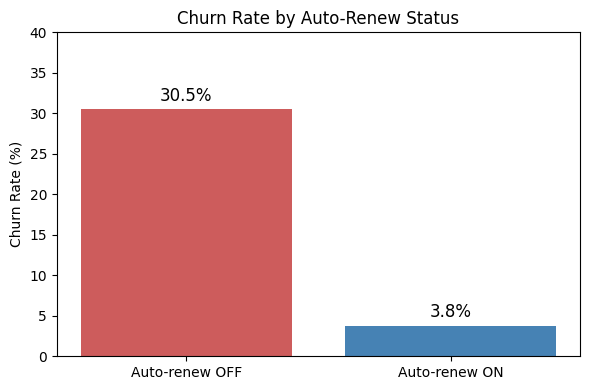

In [21]:
# Churn rate by auto-renew status
auto_renew_labels = ['Auto-renew OFF', 'Auto-renew ON']
churn_rates = [30.5, 3.8]

plt.figure(figsize=(6, 4))
plt.bar(auto_renew_labels, churn_rates, color=['indianred', 'steelblue'])
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Auto-Renew Status')
for i, v in enumerate(churn_rates):
    plt.text(i, v + 1, f'{v}%', ha='center', fontsize=12)
plt.ylim(0, 40)
plt.tight_layout()
plt.show()

Auto-renew is the strongest predictor. Users without auto-renew churn at 30.5%, compared to 3.8% with auto-renew (8x difference).

In [22]:
# Churn rate by payment plan days (most recent transaction)
plan_churn_df = run_query("""
WITH latest_transaction AS (
    SELECT 
        msno,
        payment_plan_days,
        ROW_NUMBER() OVER (PARTITION BY msno ORDER BY transaction_date DESC) as rn
    FROM kkbox.transactions
)
SELECT 
    lt.payment_plan_days,
    COUNT(*) as users,
    SUM(t.is_churn) as churned,
    ROUND(SUM(t.is_churn) * 100.0 / COUNT(*), 1) as churn_rate
FROM kkbox.train t
JOIN latest_transaction lt ON t.msno = lt.msno
WHERE lt.rn = 1
GROUP BY lt.payment_plan_days
HAVING COUNT(*) >= 500
ORDER BY churn_rate DESC
""")
plan_churn_df

,payment_plan_days,users,churned,churn_rate
0,410,4380,4356,99.5
1,180,2914,2899,99.5
2,195,2895,2881,99.5
3,100,643,639,99.4
4,360,1206,1189,98.6
5,90,3737,3479,93.1
6,60,514,357,69.5
7,30,915285,40214,4.4


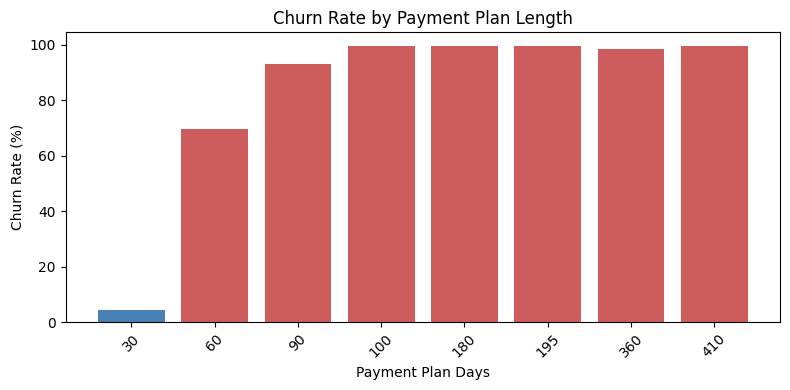

In [23]:
# Churn rate by payment plan days
fig, ax = plt.subplots(figsize=(8, 4))
plan_sorted_df = plan_churn_df.sort_values('payment_plan_days')
colors = ['steelblue' if days == 30 else 'indianred' for days in plan_sorted_df['payment_plan_days']]
ax.bar(plan_sorted_df['payment_plan_days'].astype(str), plan_sorted_df['churn_rate'], color=colors)
ax.set_xlabel('Payment Plan Days')
ax.set_ylabel('Churn Rate (%)')
ax.set_title('Churn Rate by Payment Plan Length')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Long-term plans show extremely high churn rates: 180, 195, 360, and 410-day plans all have 98-99.5% churn. The standard 30-day plan has only 4.4% churn.

Since auto-renew is such a dominant factor in predicting churn, these longer plans may not have auto-renew enabled, requiring users to actively re-subscribe when they expire.

In [24]:
# Is auto-renew correlated with plan length?
run_query("""
WITH latest_transaction AS (
    SELECT 
        msno,
        payment_plan_days,
        is_auto_renew,
        ROW_NUMBER() OVER (PARTITION BY msno ORDER BY transaction_date DESC) as rn
    FROM kkbox.transactions
)
SELECT 
    payment_plan_days,
    ROUND(AVG(is_auto_renew) * 100, 1) as pct_auto_renew,
    COUNT(*) as users
FROM latest_transaction
WHERE rn = 1
GROUP BY payment_plan_days
HAVING COUNT(*) >= 500
ORDER BY payment_plan_days
""")

,payment_plan_days,pct_auto_renew,users
0,7,0.0,7790
1,30,91.1,1011027
2,60,0.0,976
3,90,0.0,15242
4,100,0.0,3947
5,120,0.0,1886
6,180,0.0,23331
7,195,0.0,26149
8,200,0.0,2933
9,270,0.0,897


Confirmed. Only the 30-day plan has auto-renew (91.1%). All other plan lengths have 0% auto-renew. The 7-day plan is likely a trial period.

This explains the churn pattern: longer plans are one-time purchases requiring manual renewal. 

## Listening Behavior and Churn

In [25]:
# Average listening activity in last 30 days before expiration by churn status
run_query("""
WITH user_last_30_days AS (
    SELECT 
        ul.msno,
        COUNT(*) as active_days,
        SUM(ul.num_100) as songs_completed,
        SUM(ul.total_secs) / 3600 as hours_listened
    FROM kkbox.user_logs ul
    WHERE ul.date >= 20170101 AND ul.date <= 20170131
      AND ul.total_secs >= 0 AND ul.total_secs <= 57600
    GROUP BY ul.msno
)
SELECT 
    t.is_churn,
    COUNT(*) as users,
    ROUND(AVG(COALESCE(u.active_days, 0)), 1) as avg_active_days,
    ROUND(AVG(COALESCE(u.songs_completed, 0)), 0) as avg_songs_completed,
    ROUND(AVG(COALESCE(u.hours_listened, 0)), 1) as avg_hours_listened
FROM kkbox.train t
LEFT JOIN user_last_30_days u ON t.msno = u.msno
GROUP BY t.is_churn
ORDER BY t.is_churn
""")

,is_churn,users,avg_active_days,avg_songs_completed,avg_hours_listened
0,0,883630,13.3,391.0,28.5
1,1,87330,13.6,413.0,30.2


Surprising result: churned users were slightly more active in their final month (13.6 active days vs 13.3, 30.2 hours vs 28.5). Combined with the retention analysis showing no difference in early engagement, listening activity does not appear to predict churn.

In [26]:
# Look at users with no listening activity in final month
run_query("""
WITH user_last_30_days AS (
    SELECT 
        ul.msno,
        COUNT(*) as active_days
    FROM kkbox.user_logs ul
    WHERE ul.date >= 20170101 AND ul.date <= 20170131
    GROUP BY ul.msno
)
SELECT 
    t.is_churn,
    COUNT(*) as total_users,
    SUM(CASE WHEN u.msno IS NULL THEN 1 ELSE 0 END) as no_activity,
    ROUND(SUM(CASE WHEN u.msno IS NULL THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) as pct_no_activity
FROM kkbox.train t
LEFT JOIN user_last_30_days u ON t.msno = u.msno
GROUP BY t.is_churn
ORDER BY t.is_churn
""")

,is_churn,total_users,no_activity,pct_no_activity
0,0,883630,214999,24.3
1,1,87330,22092,25.3


About 25% of users had no listening activity in Jan 2017, nearly identical between churned (25.3%) and retained (24.3%). Churn appears to be driven by subscription mechanics, not engagement patterns.

## Summary

**Strong churn predictors:**
- Auto-renew: 3.8% vs 30.5% churn (8x difference) - the dominant factor
- Plan type: 30-day plans have 4.4% churn; longer plans 69.5-99.5% (no auto-renew available)
- Registration channel: Channel 7 has 4.5% churn, channel 4 has 23.1%
- Age: Younger users churn more (28.2% for 13-17, declining to 8.8% for 55-64)

**Not predictive:**
- Gender shows no difference (12.9% vs 13.0%)
- Listening activity: Churned users were slightly *more* active in their final month
- Inactivity: ~25% of both churned and retained users had no Jan 2017 activity

**Key insight:**
Churn appears to be driven by subscription mechanics (auto-renew, plan type) rather than demographics or listening behavior